In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcdefaults()
import quandl
import pandas as pd
import numpy as np
import functools
import statistics
import math
import os
from datetime import datetime, timedelta
import random
import scipy as sp
import warnings
import gzip
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")
pd.options.mode.chained_assignment = None
from pyfinance.ols import PandasRollingOLS
import statsmodels
from statsmodels.regression.rolling import RollingOLS
#warnings.filterwarnings("ignore")

# Arjun Kilaru
12212837
## Quantitative Trading Strategies
# Predictive Regression

## 1.1 Loading the Data
Here we will load the downloaded CDS data.

In [5]:
cds = pd.read_csv('Liq5yCDS.delim', delim_whitespace = True)
cds.index = cds['date']
#del cds['date']
cds['dater'] = cds['date']

Here we will load equity adjusted close prices.

In [7]:
quandl.ApiConfig.api_key = "v2EVM2mpJPBQrcyFbxcH"
spy = quandl.get_table("QUOTEMEDIA/PRICES", qopts = { 'columns': ['ticker', 'date', 'adj_close']}, date = { 'gte': '2018-01-01', 'lte':' 2022-12-30' }, ticker='SPY')
spy.index = spy['date']
spy.index = pd.to_datetime(spy.index)
spy = spy.sort_index()
spy = spy.dropna()
spy

,ticker,date,adj_close
date,,,
2018-01-02,SPY,2018-01-02,246.612280
2018-01-03,SPY,2018-01-03,248.172130
2018-01-04,SPY,2018-01-04,249.218147
2018-01-05,SPY,2018-01-05,250.878929
2018-01-08,SPY,2018-01-08,251.337708
...,...,...,...
2022-12-23,SPY,2022-12-23,382.910000
2022-12-27,SPY,2022-12-27,381.400000
2022-12-28,SPY,2022-12-28,376.660000


In [8]:
ticks = cds['ticker'].unique().tolist()

In [9]:
def get_data():
    counter = False
    for tick in ticks:
        data = quandl.get_table("QUOTEMEDIA/PRICES", qopts = { 'columns': ['ticker', 'date', 'adj_close']}, date = { 'gte': '2018-01-01', 'lte':' 2022-12-30' }, ticker=tick)
        if counter:
            dt = pd.concat([dt, data], axis=0)
        else:
            dt = data
            counter = True
    return dt

In [10]:
prices = get_data()
prices.index = prices['date']
prices.index = pd.to_datetime(prices.index)
prices = prices.sort_index()
prices['dater'] = prices.index

In [11]:
prices

,ticker,date,adj_close,dater
date,,,,
2018-01-02,NFLX,2018-01-02,201.070000,2018-01-02
2018-01-02,BA,2018-01-02,282.831151,2018-01-02
2018-01-02,XOM,2018-01-02,64.866077,2018-01-02
2018-01-02,C,2018-01-02,63.138940,2018-01-02
2018-01-02,WFC,2018-01-02,52.555811,2018-01-02
...,...,...,...,...
2022-12-30,WFC,2022-12-30,41.029386,2022-12-30
2022-12-30,GE,2022-12-30,83.790000,2022-12-30
2022-12-30,XRX,2022-12-30,14.600000,2022-12-30


## 2.1 Calculating Wednesday-to-Wednesday Returns

Here we will calculate Wednesday-to-Wednesday returns in SPY and our CDS data.

In [12]:
weekly_df = spy.resample('W-WED').last()

# calculate the weekly returns as the percentage change in prices
weekly_returns = weekly_df['adj_close'].pct_change()

# shift the weekly returns by one period to align with the Wednesday-to-Wednesday window
weekly_returns = weekly_returns.shift(-1)

# add the weekly returns to the original dataframe
spy['m'] = weekly_returns
spy = spy.sort_index()
spy = spy.dropna()
spy

,ticker,date,adj_close,m
date,,,,
2018-01-03,SPY,2018-01-03,248.172130,0.013495
2018-01-10,SPY,2018-01-10,251.521220,0.020028
2018-01-17,SPY,2018-01-17,256.558618,0.012768
2018-01-24,SPY,2018-01-24,259.834303,-0.004520
2018-01-31,SPY,2018-01-31,258.659828,-0.050479
...,...,...,...,...
2022-11-30,SPY,2022-11-30,405.794333,-0.035616
2022-12-07,SPY,2022-12-07,391.341493,0.015871
2022-12-14,SPY,2022-12-14,397.552631,-0.028481


In [13]:
prices = prices[['ticker', 'adj_close', 'dater']]
prices['dater'] = prices['dater'].astype(str)
cds['dater'] = cds['dater'].astype(str)

merged_df = pd.merge(cds, prices, on=['ticker', 'dater'], how='inner')
merged_df.index = merged_df['date']
df = merged_df
df['ticker2'] = df['ticker']
df = df.set_index(['date', 'ticker'])
df

tenor  parspread   upfront  runningcoupon  cdsrealrecovery  \
date       ticker                                                              
2018-01-02 BA        5Y   0.001768 -0.039014           0.01         0.400000   
           C         5Y   0.004100 -0.027751           0.01         0.400000   
           DD        5Y   0.002483 -0.035587           0.01         0.400000   
           F         5Y   0.008663 -0.006251           0.01         0.393333   
           GE        5Y   0.004077 -0.216270           0.05         0.400000   
...                 ...        ...       ...            ...              ...   
2022-12-30 NFLX      5Y   0.014090  0.017825           0.01         0.396650   
           T         5Y   0.011370  0.006043           0.01         0.396667   
           WFC       5Y   0.008301 -0.184861           0.05         0.400000   
           XOM       5Y   0.004110 -0.206613           0.05         0.400000   
           XRX       5Y   0.042346  0.128919           0.01         0.400000   

                   cdsassumedrecovery docclause currency    tier  \
date       ticker                                                  
2018-01-02 BA                     0.4      MR14      USD  SNRFOR   
           C                      0.4      MR14      USD  SNRFOR   
           DD                     0.4      MR14      USD  SNRFOR   
           F                      0.4      MR14      USD  SNRFOR   
           GE                     0.4      MR14      USD  SNRFOR   
...                               ...       ...      ...     ...   
2022-12-30 NFLX                   0.4      MR14      USD  SNRFOR   
           T                      0.4      MR14      USD  SNRFOR   
           WFC                    0.4      MR14      USD  SNRFOR   
           XOM                    0.4      MR14      USD  SNRFOR   
           XRX                    0.4      MR14      USD  SNRFOR   

                  impliedrating       dater   adj_close ticker2  
date       ticker                                                
2018-01-02 BA               BBB  2018-01-02  282.831151      BA  
           C                  A  2018-01-02   63.138940       C  
           DD                 A  2018-01-02   93.446821      DD  
           F                 BB  2018-01-02    9.868842       F  
           GE               BBB  2018-01-02  132.665888      GE  
...                         ...         ...         ...     ...  
2022-12-30 NFLX             BBB  2022-12-30  294.880000    NFLX  
           T                BBB  2022-12-30   18.145536       T  
           WFC                A  2022-12-30   41.029386     WFC  
           XOM               AA  2022-12-30  109.454469     XOM  
           XRX                B  2022-12-30   14.600000     XRX  

[18443 rows x 13 columns]

In [14]:
df['weekly_price_ret'] = 0
df['weekly_cds_ret'] = 0
def impute_weekly_returns(df, stat):
    df = df.copy()
    df = df.reset_index()
    df.index = df['dater']
    df.index = pd.to_datetime(df.index)
    weekly_df = df.resample('W-WED').last()
    weekly_returns = weekly_df['adj_close'].pct_change()
    weekly_returns2 = weekly_df['parspread'].pct_change()
    weekly_returns = weekly_returns.shift(-1)
    weekly_returns2 = weekly_returns2.shift(-1)
    df['r_equity'] = weekly_returns
    df['r_cds'] = weekly_returns2
    return df

In [15]:
df1 = df.groupby(level='ticker').apply(impute_weekly_returns, 'adj_close')
df2 = df1.stack().unstack('ticker')
df2 = df1.swaplevel().sort_index()
df3 = df2[df2['r_equity'].notna()]

## 2.2 Calculate Arithmetic Mean
Here we will calculate the arithmetic mean of our CDS returns. 

In [16]:
def get_rindex(df):
    rolling_means = [df['r_cds'][:i+1].mean() for i in range(len(df))]
    df['r_index'] = rolling_means
    return df
df3 = df3.groupby(level='ticker').apply(get_rindex)

In [17]:
df4 = df3[['parspread', 'adj_close', 'r_equity', 'r_cds', 'r_index']]
df4

parspread   adj_close  r_equity     r_cds   r_index
dater      ticker                                                     
2018-01-03 BA       0.001682  283.745845  0.075420 -0.057555 -0.057555
           C        0.004080   63.334233  0.014211 -0.002449 -0.002449
           DD       0.002425   94.941450  0.015743  0.012286  0.012286
           F        0.008474    9.946795  0.021160  0.017203  0.017203
           GE       0.004076  133.920238  0.042920  0.009527  0.009527
...                      ...         ...       ...       ...       ...
2022-12-28 NFLX     0.014034  276.880000  0.065010  0.004029  0.004011
           T        0.011367   17.958266  0.010428  0.000281  0.003319
           WFC      0.008228   40.860459  0.004134  0.008787  0.006414
           XOM      0.004068  107.549187  0.017715  0.010353  0.001977
           XRX      0.042453   14.370000  0.016006 -0.002516  0.006727

[3766 rows x 5 columns]

## 2.3 Compute Boxcar Regression Estimates
Here we will calculate our boxcar estimates of the CAPM and hedge portfolio.

In [18]:
def get_boxcar_preds(df):
    rolling_ols = RollingOLS(df['r_cds'], df[['r_equity', 'r_index']], window=16)
    rolling_res = rolling_ols.fit()
    params = rolling_res.params.copy()
    params.index = df.index
    df['f'] =  params['r_equity']*df['r_equity'] + params['r_index'] * df['r_index']
    a = df.index.get_level_values('dater')[0]   
    spycop = spy.loc[a:]
    b = spycop['m'].tolist()
    df['spy'] = b
    capm = RollingOLS(df['r_equity'], df['spy'], window=16)
    capmfit = capm.fit()
    capmparams = capmfit.params.copy()
    capmparams.index = df.index
    df['capm 1'] =  capmparams['spy']*df['spy']
    return df

df5 = df4.groupby(level='ticker').apply(get_boxcar_preds)

## 2.4 Compute Residuals
Here we will compute our residuals from the boxcar regressions.

In [114]:
def residual_return(df):
    df['rho'] = df['r_cds'] - df['f']
    df['c'] = df['r_equity'] - df['capm 1']
    df['c-1'] = df['c'].shift(1)
    return df

df5 = df5.groupby(level='ticker').apply(residual_return)

In [23]:
def exp_1_2_reg(_df):
    halflife = 12
    lma = 2**(-1./halflife)
    threshold = 1. / (df.shape[0]* 500)
    exp_1p2_wts = w12[ w12 > threshold]

    
    _df = _df.dropna()
    _n = min(exp_1p2_wts.shape[0], _df.shape[0])
    _ldf = _df.iloc[-_n:]
    _wt = exp_1p2_wts[-_n:]
    _p = linreg.WLS(_ldf['rho'], _ldf[['c-1']], weights=_wt).fit(params_only=True).params
    return (pd.DataFrame(data=[_p], index=[_df.index[-1]]), exp_1p2_wts)

In [35]:
from sklearn.linear_model import LinearRegression
import statsmodels.regression.linear_model as linreg

half_life = 12
lma = 2**(-1./half_life)
threshold = 1. / (df6.shape[0]* 500)
w12 = lma**np.arange(df6.shape[0]-1, -1, -1)
exp_1p2_wts = w12[ w12 > threshold]

def get_exp_regs(df):
    exp_1_2_coeffs = pd.concat([exp_1_2_reg(df.iloc[max(0,i-exp_1p2_wts.shape[0]):i]) for i in range(1, df.shape[0])])
    df['exp_weighted reg'] = exp_1_2_coeffs['c-1'].tolist() * df.iloc[:-1]['c-1']
    df['exp_weighted resid'] = df['rho'] - df['exp_weighted reg']
    return df

df6 = df5.dropna()
df6 = df6.groupby(level='ticker').apply(get_exp_regs)


In [113]:
def get_boxcar_preds(df):
    rolling_ols = RollingOLS(df['rho'], df[['c-1']], window=16)
    rolling_res = rolling_ols.fit()
    params = rolling_res.params.copy()
    params.index = df.index
    df['boxcar preds'] =  params['c-1']*df['c-1']
    df['boxcar prediction residuals'] = df['rho'] - df['boxcar preds']
    return df
df7 = df6.groupby(level = 'ticker').apply(get_boxcar_preds)

## 3.1 Residual Analysis: Model Parameters
Here, we will analyze the residuals of each prediction to assess the goodness of fit. 

In [662]:
tickers = df7.index.get_level_values('ticker').unique().tolist()

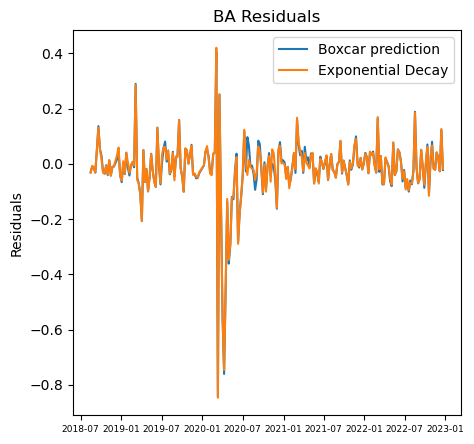

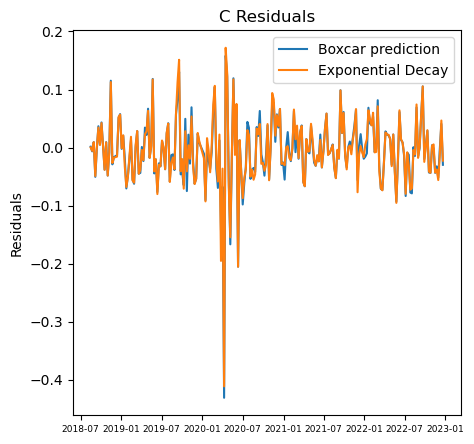

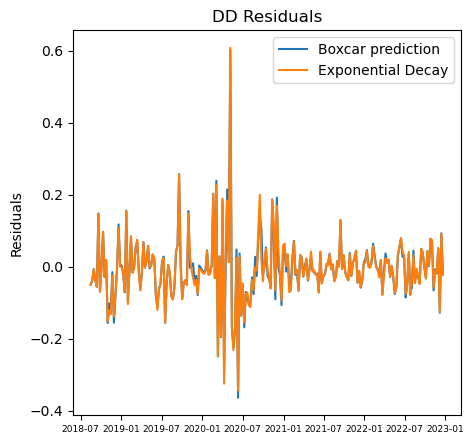

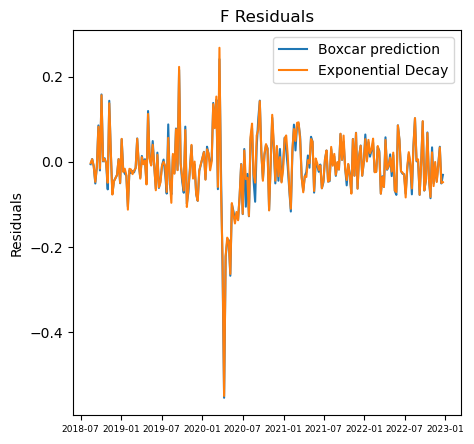

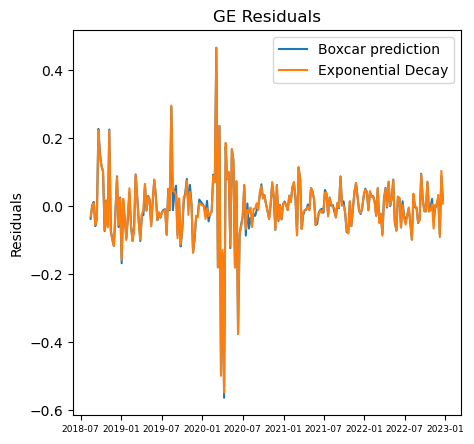

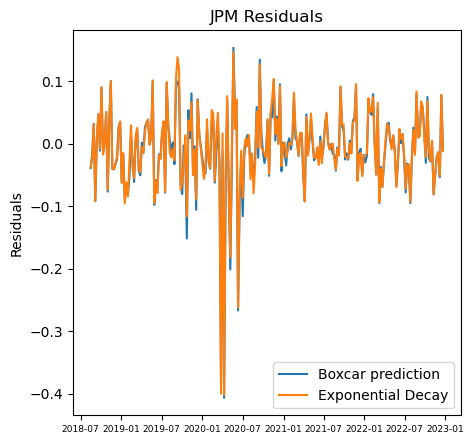

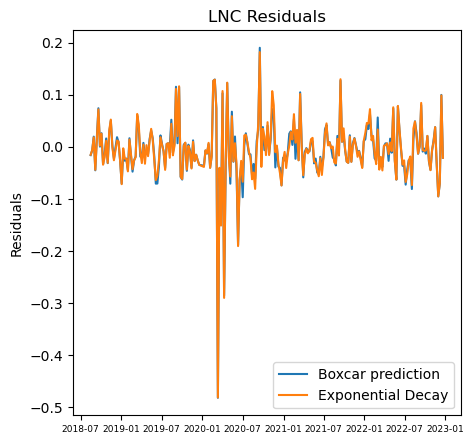

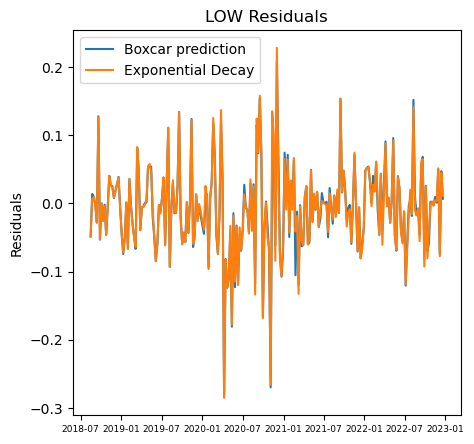

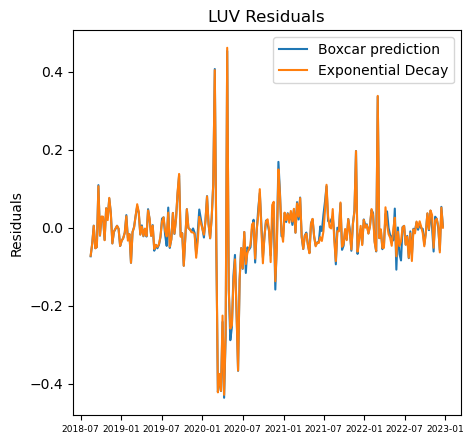

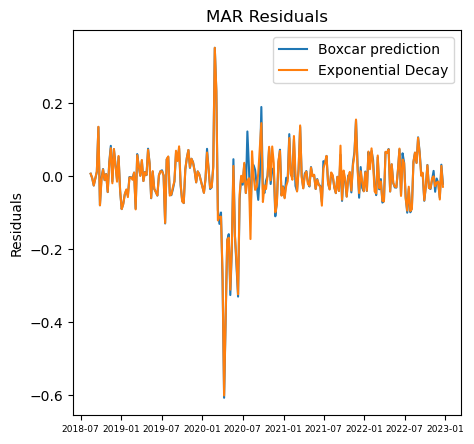

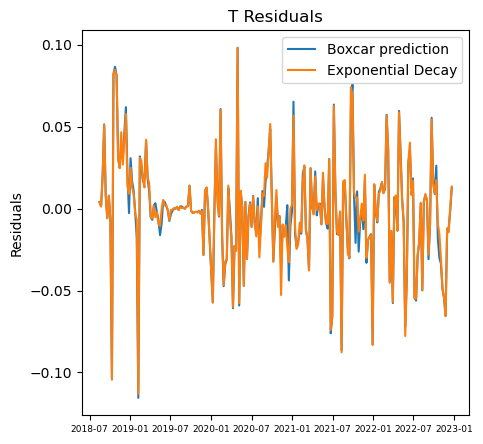

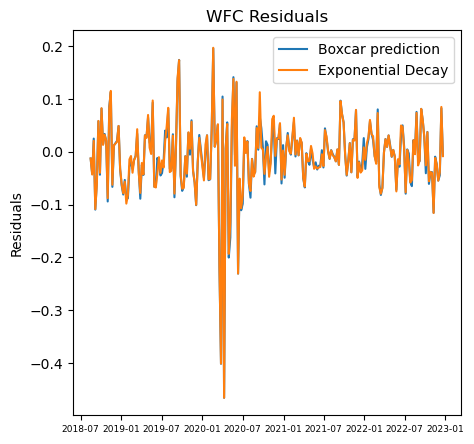

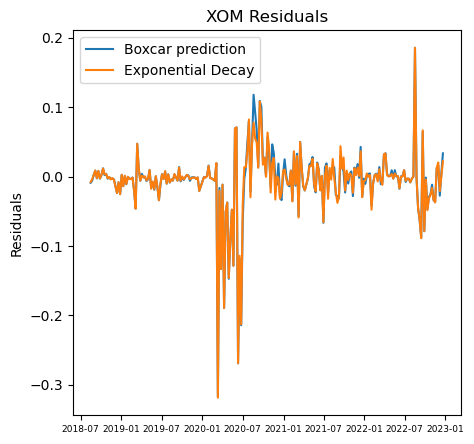

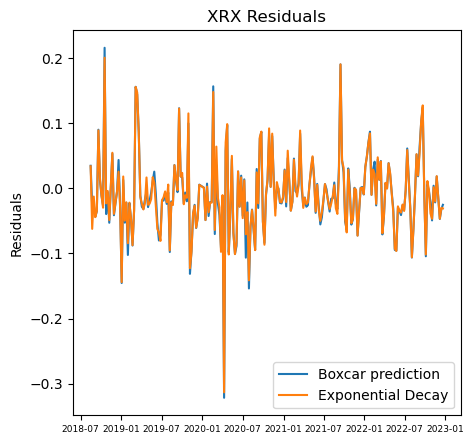

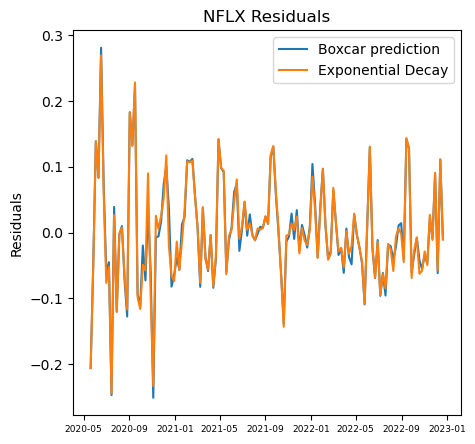

,RSS Boxcar,RSS Exponential
BA,3.210067,3.156910
C,0.745045,0.751134
DD,1.784410,1.795715
F,1.372314,1.348660
GE,1.917317,1.896380
JPM,0.952475,0.959921
LNC,0.782163,0.794843
LOW,0.919257,0.947229
LUV,2.178702,2.130887
MAR,1.763795,1.721699


In [97]:
import matplotlib.dates as mdates
def plot_residuals(df):
    rsslist1 = []
    rsslist2 = []
    tickers = df.index.get_level_values('ticker').unique().tolist()
    for tick in tickers:
        subdf = df.xs(tick, level = 'ticker', drop_level = False)
        times = subdf.index.get_level_values('dater').unique().tolist()
        rss1 = (subdf['boxcar prediction residuals']**2).cumsum()[-1]
        rsslist1.append(rss1)
        rss2 = (subdf['exp_weighted resid']**2).cumsum()[-1]
        rsslist2.append(rss2)
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(1, 1, 1)
        x_values = subdf.index.get_level_values('dater')
        ax.plot(x_values, subdf['boxcar prediction residuals'].tolist(), label = 'Boxcar prediction')
        ax.plot(x_values, subdf['exp_weighted resid'].tolist(), label = 'Exponential Decay')
        ax.set_title(tick + str(" Residuals"))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.tick_params(axis='x', which='major', labelsize=6.5)
        plt.ylabel("Residuals")
        plt.legend()
        plt.show()
    r = pd.DataFrame()
    r.index = tickers
    r['RSS Boxcar'] = rsslist1
    r['RSS Exponential'] = rsslist2
    return r

resids = plot_residuals(df7.dropna())
resids

Looking at the residuals, it is clear that the exponential decay regression performs better in most cases. in 10/15 of the tickers, the exponential regression had a lower total sum of squares, indicated smaller residuals. This is likely because more information is captured through the exponential decaying regression, whereas the boxcar regression only takes into account the last sixteen weeks. In order to further examine the differences between both regressions, we can change around the boxcar window or the half life and see if we can minimize the residual sum of squares.

In [106]:
def get_boxcar_preds2(df):
    rolling_ols = RollingOLS(df['rho'], df[['c-1']], window=25)
    rolling_res = rolling_ols.fit()
    params = rolling_res.params.copy()
    params.index = df.index
    df['boxcar preds'] =  params['c-1']*df['c-1']
    df['boxcar prediction residuals'] = df['rho'] - df['boxcar preds']
    return df
df7_two = df6.groupby(level = 'ticker').apply(get_boxcar_preds2)

def calculate_rss2(df):
    df = df.dropna()
    rsslist1 = []
    tickers = df.index.get_level_values('ticker').unique().tolist()
    for tick in tickers:
        subdf = df.xs(tick, level = 'ticker', drop_level = False)
        rss1 = (subdf['boxcar prediction residuals']**2).cumsum()[-1]
        rsslist1.append(rss1)
    r = pd.DataFrame()
    r.index = tickers
    r['RSS Boxcar (w = 20)'] = rsslist1
    return r
resids['RSS Boxcar (w = 25)'] = calculate_rss2(df7_two)['RSS Boxcar (w = 20)']

def get_boxcar_preds3(df):
    rolling_ols = RollingOLS(df['rho'], df[['c-1']], window=6)
    rolling_res = rolling_ols.fit()
    params = rolling_res.params.copy()
    params.index = df.index
    df['boxcar preds'] =  params['c-1']*df['c-1']
    df['boxcar prediction residuals'] = df['rho'] - df['boxcar preds']
    return df
df7_three = df6.groupby(level = 'ticker').apply(get_boxcar_preds3)

def calculate_rss3(df):
    df = df.dropna()
    rsslist1 = []
    tickers = df.index.get_level_values('ticker').unique().tolist()
    for tick in tickers:
        subdf = df.xs(tick, level = 'ticker', drop_level = False)
        rss1 = (subdf['boxcar prediction residuals']**2).cumsum()[-1]
        rsslist1.append(rss1)
    r = pd.DataFrame()
    r.index = tickers
    r['RSS Boxcar (w = 20)'] = rsslist1
    return r
resids['RSS Boxcar (w = 6)'] = calculate_rss3(df7_three)['RSS Boxcar (w = 20)']

resids

,RSS Boxcar,RSS Exponential,RSS Boxcar (w = 25),RSS Boxcar (w = 6)
BA,3.210067,3.156910,3.253390,2.923370
C,0.745045,0.751134,0.782125,0.673172
DD,1.784410,1.795715,1.833730,1.670302
F,1.372314,1.348660,1.352735,1.276547
GE,1.917317,1.896380,1.865986,1.612255
JPM,0.952475,0.959921,1.002503,0.856770
LNC,0.782163,0.794843,0.818517,0.741620
LOW,0.919257,0.947229,0.942369,0.860023
LUV,2.178702,2.130887,2.220109,1.857947
MAR,1.763795,1.721699,1.781464,1.467695


We see that in 10/15 instances, the RSS increases when increasing the boxcar window size to 20, as oppposed to 16. This may be because 20 weeks is too long of a window to add meaningful information that would improve regression outcomes. We will now try another method where we change the half life to 24, doubling the previous metric.

In [108]:
def exp_1_2_reg2(_df):
    halflife = 24
    lma = 2**(-1./halflife)
    threshold = 1. / (df.shape[0]* 500)
    exp_1p2_wts = w12[ w12 > threshold]

    
    _df = _df.dropna()
    _n = min(exp_1p2_wts.shape[0], _df.shape[0])
    _ldf = _df.iloc[-_n:]
    _wt = exp_1p2_wts[-_n:]
    _p = linreg.WLS(_ldf['rho'], _ldf[['c-1']], weights=_wt).fit(params_only=True).params
    return pd.DataFrame(data=[_p], index=[_df.index[-1]])


def get_exp_regs(df):
    exp_1_2_coeffs = pd.concat([exp_1_2_reg2(df.iloc[max(0,i-exp_1p2_wts.shape[0]):i]) for i in range(1, df.shape[0])])
    df['exp_weighted reg'] = exp_1_2_coeffs['c-1'].tolist() * df.iloc[:-1]['c-1']
    df['exp_weighted resid'] = df['rho'] - df['exp_weighted reg']
    return df

In [109]:
half_life = 24
lma = 2**(-1./half_life)
threshold = 1. / (df6.shape[0]* 500)
w12 = lma**np.arange(df6.shape[0]-1, -1, -1)
exp_1p2_wts = w12[ w12 > threshold]

df7_three = df6.groupby(level='ticker').apply(get_exp_regs)


In [110]:
def calculate_rss(df):
    df = df.dropna()
    rsslist1 = []
    tickers = df.index.get_level_values('ticker').unique().tolist()
    for tick in tickers:
        subdf = df.xs(tick, level = 'ticker', drop_level = False)
        rss1 = (subdf['exp_weighted resid']**2).cumsum()[-1]
        rsslist1.append(rss1)
    r = pd.DataFrame()
    r.index = tickers
    r['RSS Exp Weighted (half-life = 24)'] = rsslist1
    return r

resids['RSS Exp Weighted (h/l = 24)'] = calculate_rss(df7_three)['RSS Exp Weighted (half-life = 24)']
resids

,RSS Boxcar,RSS Exponential,RSS Boxcar (w = 25),RSS Boxcar (w = 6),RSS Exp Weighted (h/l = 24)
BA,3.210067,3.156910,3.253390,2.923370,3.302493
C,0.745045,0.751134,0.782125,0.673172,0.818955
DD,1.784410,1.795715,1.833730,1.670302,1.889528
F,1.372314,1.348660,1.352735,1.276547,1.412411
GE,1.917317,1.896380,1.865986,1.612255,2.020834
JPM,0.952475,0.959921,1.002503,0.856770,1.043699
LNC,0.782163,0.794843,0.818517,0.741620,0.849381
LOW,0.919257,0.947229,0.942369,0.860023,1.011136
LUV,2.178702,2.130887,2.220109,1.857947,2.286893
MAR,1.763795,1.721699,1.781464,1.467695,1.800769


In [111]:
half_life = 6
lma = 2**(-1./half_life)
threshold = 1. / (df6.shape[0]* 500)
w12 = lma**np.arange(df6.shape[0]-1, -1, -1)
exp_1p2_wts = w12[ w12 > threshold]

df7_three = df6.groupby(level='ticker').apply(get_exp_regs)
def calculate_rss(df):
    df = df.dropna()
    rsslist1 = []
    tickers = df.index.get_level_values('ticker').unique().tolist()
    for tick in tickers:
        subdf = df.xs(tick, level = 'ticker', drop_level = False)
        rss1 = (subdf['exp_weighted resid']**2).cumsum()[-1]
        rsslist1.append(rss1)
    r = pd.DataFrame()
    r.index = tickers
    r['RSS Exp Weighted (half-life = 24)'] = rsslist1
    return r

resids['RSS Exp Weighted (h/l = 6)'] = calculate_rss(df7_three)['RSS Exp Weighted (half-life = 24)']
resids

,RSS Boxcar,RSS Exponential,RSS Boxcar (w = 25),RSS Boxcar (w = 6),RSS Exp Weighted (h/l = 24),RSS Exp Weighted (h/l = 6)
BA,3.210067,3.156910,3.253390,2.923370,3.302493,2.964921
C,0.745045,0.751134,0.782125,0.673172,0.818955,0.697276
DD,1.784410,1.795715,1.833730,1.670302,1.889528,1.696133
F,1.372314,1.348660,1.352735,1.276547,1.412411,1.270099
GE,1.917317,1.896380,1.865986,1.612255,2.020834,1.746075
JPM,0.952475,0.959921,1.002503,0.856770,1.043699,0.892701
LNC,0.782163,0.794843,0.818517,0.741620,0.849381,0.747768
LOW,0.919257,0.947229,0.942369,0.860023,1.011136,0.894572
LUV,2.178702,2.130887,2.220109,1.857947,2.286893,1.965350
MAR,1.763795,1.721699,1.781464,1.467695,1.800769,1.642965


In [112]:
half_life = 1
lma = 2**(-1./half_life)
threshold = 1. / (df6.shape[0]* 500)
w12 = lma**np.arange(df6.shape[0]-1, -1, -1)
exp_1p2_wts = w12[ w12 > threshold]

df7_three = df6.groupby(level='ticker').apply(get_exp_regs)
def calculate_rss(df):
    df = df.dropna()
    rsslist1 = []
    tickers = df.index.get_level_values('ticker').unique().tolist()
    for tick in tickers:
        subdf = df.xs(tick, level = 'ticker', drop_level = False)
        rss1 = (subdf['exp_weighted resid']**2).cumsum()[-1]
        rsslist1.append(rss1)
    r = pd.DataFrame()
    r.index = tickers
    r['RSS Exp Weighted (half-life = 24)'] = rsslist1
    return r

resids['RSS Exp Weighted (h/l = 1)'] = calculate_rss(df7_three)['RSS Exp Weighted (half-life = 24)']
resids

,RSS Boxcar,RSS Exponential,RSS Boxcar (w = 25),RSS Boxcar (w = 6),RSS Exp Weighted (h/l = 24),RSS Exp Weighted (h/l = 6),RSS Exp Weighted (h/l = 1)
BA,3.210067,3.156910,3.253390,2.923370,3.302493,2.964921,1.586530
C,0.745045,0.751134,0.782125,0.673172,0.818955,0.697276,0.431314
DD,1.784410,1.795715,1.833730,1.670302,1.889528,1.696133,1.071703
F,1.372314,1.348660,1.352735,1.276547,1.412411,1.270099,0.790371
GE,1.917317,1.896380,1.865986,1.612255,2.020834,1.746075,1.030302
JPM,0.952475,0.959921,1.002503,0.856770,1.043699,0.892701,0.566118
LNC,0.782163,0.794843,0.818517,0.741620,0.849381,0.747768,0.560321
LOW,0.919257,0.947229,0.942369,0.860023,1.011136,0.894572,0.519185
LUV,2.178702,2.130887,2.220109,1.857947,2.286893,1.965350,1.047234
MAR,1.763795,1.721699,1.781464,1.467695,1.800769,1.642965,1.007618


With a longer half life, nearly every ticker experiences a higher Residual sum of squares. As such, a half life of 24 is clearly too large to consider. Consequently, with a shorter half life, our RSS drops dramatically. With a half life of 1, we have much smaller residuals in every case, and with a half life of 6, our residuals are smaller in 14/15 tickers. Thus, when creating a model, it may be useful to consider a shorter half life to improve accuracy. Consequently, when we make our boxcar window shorter, in 14/15 tickers we observed a lower RSS. This could indicaate that information from preceding weeks is the biggest indicator of current returns, which prompts the question regarding AR / MA / ARIMA models serving as useful projection techniques given their emphasis on past performance. Nonetheless, the RSS from our best performing Boxcar model was still worse than the RSS from our best performing Exponential Decay model, indicating that the latter is overall a better approximator of returns. 

## 3.2 Residual Analysis: Temporal Activity
Now, we will look at our residuals and mark intertemporal occurances.

Refer back to the residual plots above, which were made with our original parameters of boxcar window = 16 and half life = 12. I noticed that these plots all had significant negative residuals, typically the greatest negative residuals during the entire time window, during the period between 01-2020 and 07-2020. Negative residuals mean that our predicted value was too high. Clearly, this coincides with the of the onset of the COVID-19 pandemic, where the global shutdown negatively affected companies across sectors. As such, during a short period of time, the market crashed, and many companies lost significant market capitalization and their adjusted close price dropped more than expected or predicted. Especially when using a model such as the 16-week boxcar model, where the prior sixteen weeks were taken into account, none of the information in that time period would have provided any information in predicting the incoming crash. Quite notably, one ticker, "T", had positive residuals during this time period. This coincides with ATNT, which logically would have grown as a result of the pandemic lockdown, as most households relied on their Internet services in much greater capacity than before. Another ticker that did not showcase a major drop was NFLX (albiet data only starts in May of that year), which also makes sense as demand for home streaming would have likely increased as a result of the lockdowns.

If we work with shorter windows and half lives, it is certainly possible that these crashes would not result in as negative residuals, as more importance is placed on performance in immediately preceding weeks. In fact, let us plot the residuals from our boxcar window = 6 and our half life = 1 regressions.

In [123]:
half_life = 1
lma = 2**(-1./half_life)
threshold = 1. / (df6.shape[0]* 500)
w12 = lma**np.arange(df6.shape[0]-1, -1, -1)
exp_1p2_wts = w12[ w12 > threshold]

df8 = df6.groupby(level='ticker').apply(get_exp_regs)

In [124]:
def get_boxcar_preds3(df):
    rolling_ols = RollingOLS(df['rho'], df[['c-1']], window=6)
    rolling_res = rolling_ols.fit()
    params = rolling_res.params.copy()
    params.index = df.index
    df['boxcar preds'] =  params['c-1']*df['c-1']
    df['boxcar prediction residuals'] = df['rho'] - df['boxcar preds']
    return df
df8 = df8.groupby(level = 'ticker').apply(get_boxcar_preds3)

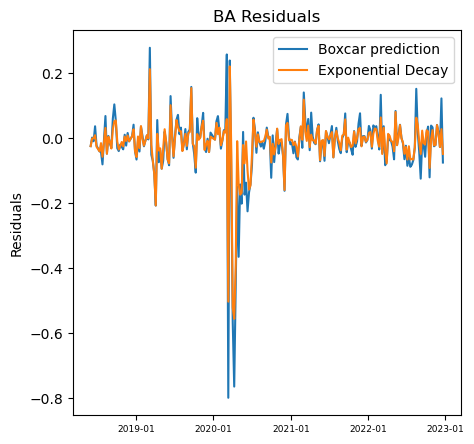

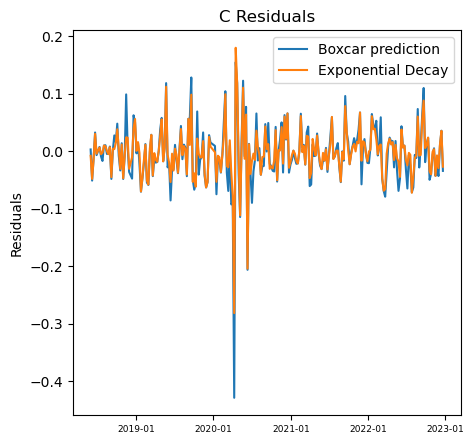

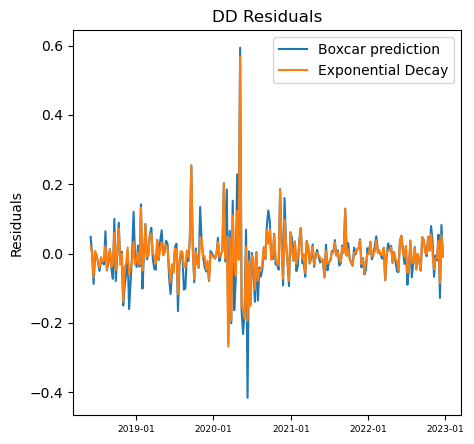

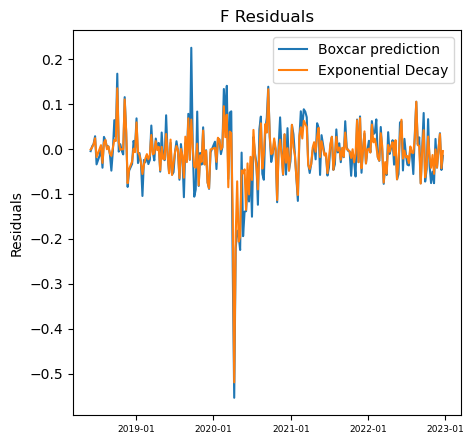

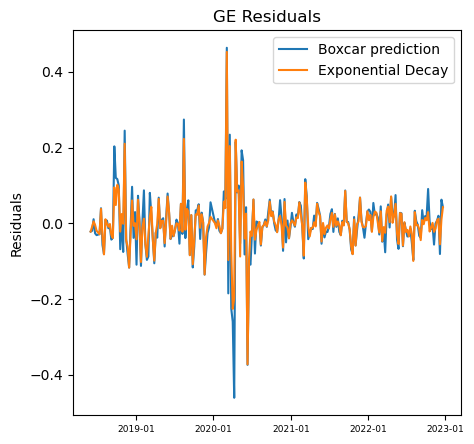

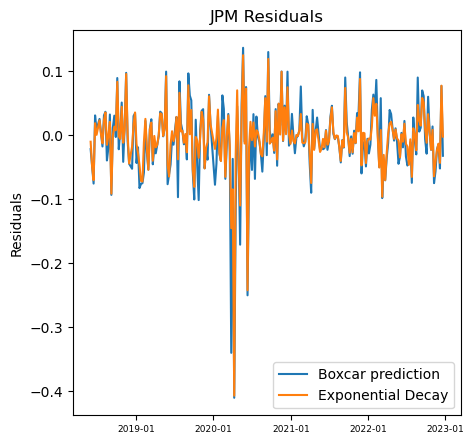

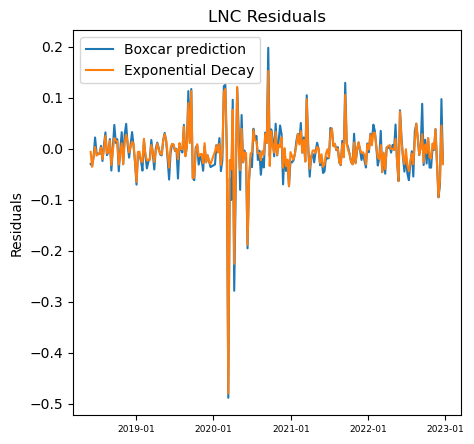

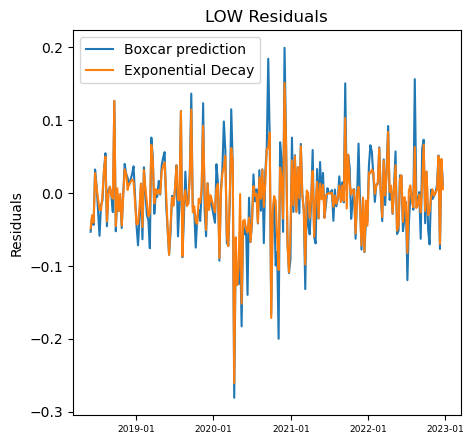

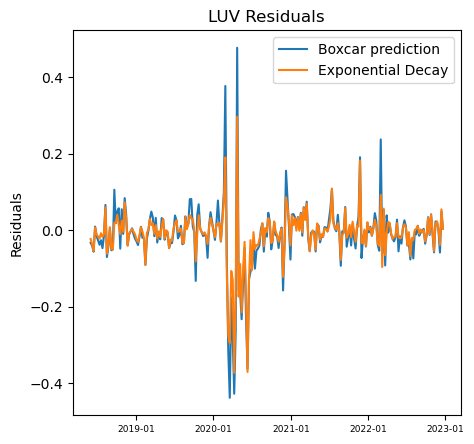

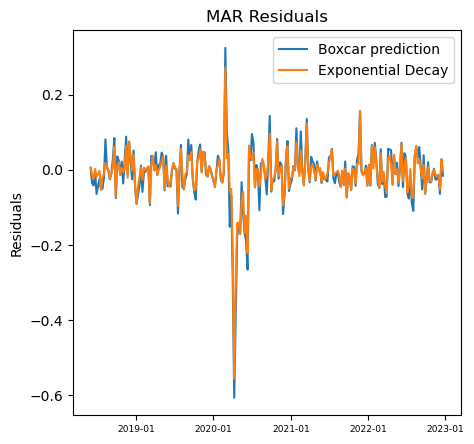

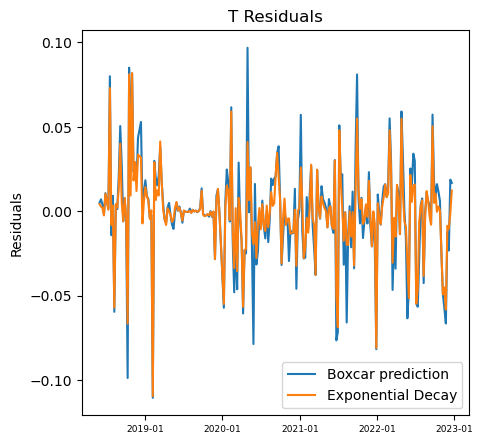

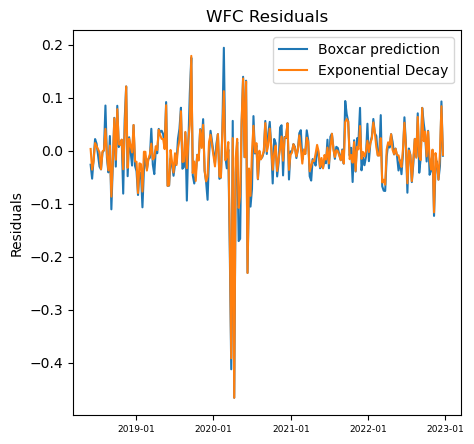

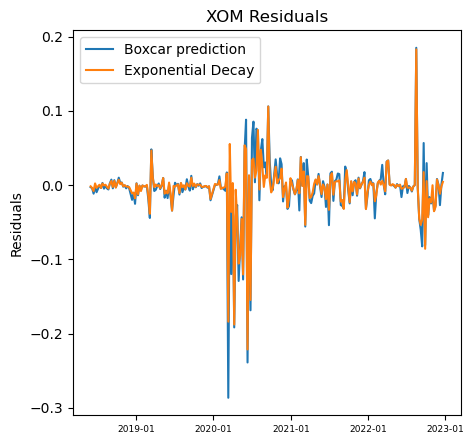

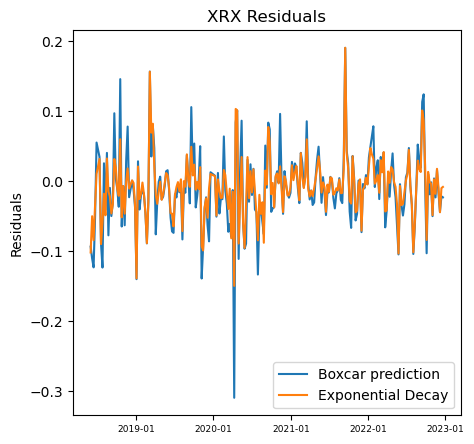

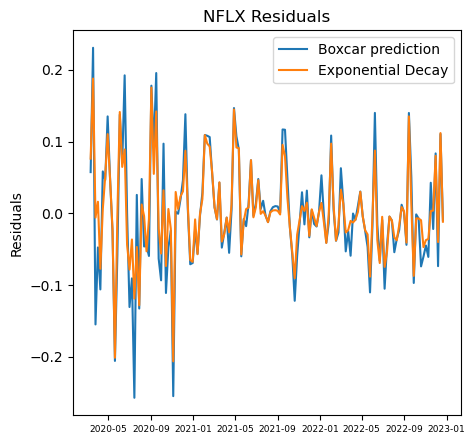

In [125]:
def plot_residuals(df):
    rsslist1 = []
    rsslist2 = []
    tickers = df.index.get_level_values('ticker').unique().tolist()
    for tick in tickers:
        subdf = df.xs(tick, level = 'ticker', drop_level = False)
        times = subdf.index.get_level_values('dater').unique().tolist()
        rss1 = (subdf['boxcar prediction residuals']**2).cumsum()[-1]
        rsslist1.append(rss1)
        rss2 = (subdf['exp_weighted resid']**2).cumsum()[-1]
        rsslist2.append(rss2)
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(1, 1, 1)
        x_values = subdf.index.get_level_values('dater')
        ax.plot(x_values, subdf['boxcar prediction residuals'].tolist(), label = 'Boxcar prediction')
        ax.plot(x_values, subdf['exp_weighted resid'].tolist(), label = 'Exponential Decay')
        ax.set_title(tick + str(" Residuals"))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.tick_params(axis='x', which='major', labelsize=6.5)
        plt.ylabel("Residuals")
        plt.legend()
        plt.show()
    r = pd.DataFrame()
    r.index = tickers
    r['RSS Boxcar'] = rsslist1
    r['RSS Exponential'] = rsslist2
    return

plot_residuals(df8.dropna())

Clearly, the residuals here are much smaller than in the previous graphs. This can especially be seen in the exponential decay model, which has especially smaller residuals then the boxcar prediction model. In the boxcar model, there is still the dip occurring at 2020, but in the exponential decay model, these crashes have not resulted in significantly negative residuals in many of the tickers.

## Conclusion

We tested the feasibility of Boxcar and Exponential Decay regression models. For both models, we tested multiple hyperparamaters to assess fit. It was found that in Boxcar models, shorter lookback periods lead to greater RSS, indicating that immediately previous weeks are better indicators of current performance. For exponential decay models, shorter half lives helped capture better information. Both of these conclusions support the concept that immediately preceding performance serves as the strongest indicator, which prompts further discussion on other models (ARMA time series, for example) that may prove useful. Lastly, analyzing temporal activity showcases how our models do not account for black swan crash events, such as the 2020 COVID pandemic. Working with shorter time windows in boxcar and decay does likely help with this and can serve as a potential fix. To conclude, we analyzed the performance of multiple regression models in fitting CDS and equity return data.